## Labs: My Model - Iteration 3 (Solution)

In this lab project, you will build a trading model based on the popular characteristics for cheap stocks: Low Price-to-Earnings ratio and low Price-to-Book ratio.

For this first iteration, we are going to extract the alphas by simply measuring the distances between the asset's pe and pb from the mean pe and pb, respectively. This operation is called *normalization*.

## 1. Imports and Settings

Copy this code cell into the algorithm:

In [1]:
# Module Imports
# --------------------
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data.morningstar import Fundamentals

from quantopian.pipeline.filters import QTradableStocksUS, StaticAssets

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import gmean

# Environment Settings
# --------------------
## Production 
universe = QTradableStocksUS()
mask = {'mask': universe}

## Development
# universe = StaticAssets(symbols(['FB']))
# mask = {'mask': universe}


# Global Configuration
# --------------------

# None, 'industry', 'sector'
SCALE_BY = 'sector'
PIPE_NORMALIZE = True
CLIP_OUTLIERS = False
CLIP_THRESHOLD =  0.025

# When true, for each day, get some % of shorts and some % of longs
USE_EXTREMES = False
EXTREMES_BOTTOM = 0.03
EXTREMES_TOP = 0.07

Do not copy this code cell into the algorithm:

In [2]:
from quantopian.research import run_pipeline

# Leave at least 6 months holding period.

## Production 
start_date = datetime.strptime('01/01/2018', '%m/%d/%Y')
end_date = datetime.strptime('06/01/2019', '%m/%d/%Y')

## Development
# start_date = datetime.strptime('03/01/2020', '%m/%d/%Y')
# end_date = datetime.strptime('03/03/2020', '%m/%d/%Y')

## 2. Helpers

The code below can be copied directly into the algorithm.

In [3]:
def get_unique(asof_date, values, num_periods=1, num_years=None):
    """ Get unique values
    Use this function to get quarterly or yearly data.
    Set num_periods to 1 for quarterly, 4 for yearly/annual.
    """
    dates, unique_indices = \
        np.unique(asof_date,return_index=True)
    dates = dates[::num_periods]
    unique_indices = unique_indices[::num_periods]
    unique_values = values[unique_indices]
    if num_years != None:
        dates = dates[-num_years-1:]
        unique_values = unique_values[-num_years-1:]
    dates = dates[1:]
    unique_values = unique_values[1:]
    
    return (unique_values, dates)


def get_changes(data, t=1):
    data = pd.Series(data)
    prev_data = data.shift(t)
    return data/prev_data


def zscore(data):
    result = pd.Series(data)
    result = result - np.nanmean(data)
        
    denom = result.std()

    return result / denom


def standardize(data, standardize_by=None, standardizer=None):
    data = pd.Series(data)
    
    # Prepare the data
    dfData = pd.DataFrame({'data': data})
    if standardize_by != None and standardizer is not None:
        dfData[standardize_by] = standardizer
    
        # Standardize the data
        zscore = lambda x: (x - x.mean()) / (x.std() == 0 and 1 or x.std())
        data = dfData.groupby([standardize_by])['data'].transform(zscore)
    
    return data


def normalize(data):
    """ Normalize long/short positions
    """
    result = pd.Series(data)
    result = result - np.nanmean(data)
        
    denom = result.abs().sum()
    if denom == 0:
        denom = 1
    
    return result / denom


def clip(data, threshold=0.025, drop=False):
    data = pd.Series(data)
    data_notnull = data[data.notnull()]
    if data_notnull.shape[0] > 0:
        low_cutoff = data_notnull.quantile(threshold)
        high_cutoff = data_notnull.quantile(1 - threshold)
        if not drop:
            data = data.clip(lower=low_cutoff, upper=high_cutoff).values
        else:
            data = data[(data < low_cutoff) | (data > high_cutoff)]
    
    return data


def get_extremes(data, n_bottom_or_both, n_top=None):
    """ Divide data into 100 bins, then get n top and bottom bins.
    """
    data_notnan = data[~np.isnan(data)]
    if n_top != None:
        n_bottom = n_bottom_or_both
        condition = (data < np.percentile(data_notnan, float(n_bottom))) | \
                    (data > np.percentile(data_notnan, 1.0-n_top))
    else:
        n = n_bottom_or_both
        condition = (data < np.percentile(data_notnan, float(n))) | \
                    (data > np.percentile(data_notnan, 1.0-n))
    return np.where(condition, data, np.nan)


class Scale(CustomFactor):
    """ Scale by either industry or sector.
    This is for a quick experiment to get scaled value
    of the last day. Once multiple dates are needed,
    a new factor needs to be created.
    """
    # inputs = [factor, classifier]
    inputs = [USEquityPricing.close.latest,
              Fundamentals.morningstar_industry_code.latest]
    window_length = 1
    params={
        'clip_outliers': False,
        'clip_threshold': 0.025,
        'scale_by': 'sector', # None, 'sector' or 'industry'
    }
    
    def compute(self, today, assets, out, input1, groupby, clip_outliers,
                clip_threshold, scale_by):
        data = input1[-1, :]

        out[:] = self.transform(data, groupby, clip_outliers,
                                clip_threshold, scale_by)
    
    
    def transform(self, data, groupby, clip_outliers,
                  clip_threshold, scale_by):
        
        if clip_outliers:
            data = clip(data, threshold=clip_threshold)

        groupby_data = groupby[-1, :]
        data = standardize(data,
                           standardize_by=scale_by,
                           standardizer=groupby_data)
        return data

    
class FScale(Scale):
    """ Scale fundamental data.
    Use periodic instead of daily values."""
    
    # asof_dates, values, groupby
    inputs = [Fundamentals.roa_asof_date, Fundamentals.roa,
              Fundamentals.morningstar_industry_code]
    
    params = {
        **{
            'period': 'yearly', # 'yearly' or 'quarterly'
            'num_years': 1
        },
        **Scale.params}
    
    
    def get_unique(self, asof_date, value):
        if self.params['period'] == 'yearly':
            t = 4
        else:
            t = 1
        return get_unique(asof_date, value,
                          num_periods=t,
                          num_years=self.params['num_years'])

        
class CFOA(FScale):
    inputs = [Fundamentals.free_cash_flow_asof_date,
              Fundamentals.free_cash_flow, Fundamentals.total_assets,
              Fundamentals.morningstar_industry_code]
    def compute(self, today, assets, out, asof_date, fcf, ta, groupby,
                period, num_years,
                clip_outliers, clip_threshold, scale_by):
        fcf_sum = np.zeros([fcf.shape[1]])
        for asset_idx in range(fcf.shape[1]):
            periodic_values, dates = self.get_unique(asof_date[:, asset_idx],
                                                     fcf[:, asset_idx])
            fcf_sum[asset_idx] = np.sum(periodic_values)
        ta = ta[-1, :]
        ta[ta == 0] = 1
        result = fcf_sum/ta
        
        out[:] = self.transform(result, groupby, clip_outliers,
                                clip_threshold, scale_by)

        
class GMean(FScale):
    inputs = [Fundamentals.roa_asof_date,
              Fundamentals.roa,
              Fundamentals.morningstar_industry_code]
    def compute(self, today, assets, out, asof_date, inp, groupby,
                period, num_years,
                clip_outliers, clip_threshold, scale_by):
        result = np.zeros([inp.shape[1]])
        for asset_idx in range(inp.shape[1]):
            periodic_values, dates = self.get_unique(asof_date[:, asset_idx],
                                                     inp[:, asset_idx])
            # If the company has not been around for that long, use
            # whatever data we have left
            periodic_values[np.isnan(periodic_values)] = 0.0
            result[asset_idx] = gmean(periodic_values+1)-1

        out[:] = self.transform(result, groupby, clip_outliers,
                                clip_threshold, scale_by)


class GMeanChanges(FScale):
    inputs = [Fundamentals.roa_asof_date,
              Fundamentals.roa,
              Fundamentals.morningstar_industry_code]
    def compute(self, today, assets, out, asof_date, inp, groupby,
                period, num_years,
                clip_outliers, clip_threshold, scale_by):
        result = np.zeros([inp.shape[1]])
        for asset_idx in range(inp.shape[1]):
            periodic_values, dates = self.get_unique(asof_date[:, asset_idx],
                                                     inp[:, asset_idx])
            changes = get_changes(periodic_values)[1:]
            # If the company has not been around for that long, use
            # whatever data we have left
            changes[np.isnan(changes)] = 0.0
            result[asset_idx] = gmean(changes+1)-1

        out[:] = self.transform(result, groupby, clip_outliers,
                                clip_threshold, scale_by)
        
        
class MeanOverStd(FScale):
    def compute(self, today, assets, out, asof_date, value, groupby,
                period, num_years,
                clip_outliers, clip_threshold, scale_by):
        result = np.zeros([value.shape[1]])
        for asset_idx in range(value.shape[1]):
            periodic_values, dates = self.get_unique(asof_date[:, asset_idx],
                                                         value[:, asset_idx])
            result[asset_idx] = np.nanmean(periodic_values) \
                                / np.nanstd(periodic_values)
        result[result == np.inf] = np.nan
        result[result == -np.inf] = np.nan

        out[:] = self.transform(result, groupby, clip_outliers,
                                        clip_threshold, scale_by)
        
        
class Max(CustomFactor):
    inputs = [],
    window_length = 1
    def compute(self, today, assets, out, inp1, inp2):
        combined = np.dstack([inp1[-1, :], inp2[-1, :]])
        result = np.amax(combined, axis=2)
        out[:] = result
        

# --- For combined factors ---

class Normalize(CustomFactor):
    window_length = 1
    def compute(self, today, assets, out, inp):
        data = normalize(inp[-1, :])
        out[:] = data

        
class Extremes(CustomFactor):
    """ Get both extremes of a factor.
    
    Pass in percentiles from the bottom and top.
    If normalized is True, normalize by taking into account
    long and short trades (use to create the final alpha factor).
    """
    window_length = 1
    params = {
        'extremes_bottom': 0.03,
        'extremes_top': 0.07,
        'normalized': False
    }
    def compute(self, today, assets, out, inp,
                extremes_bottom, extremes_top, normalized):
        data = inp[-1, :]
        data = get_extremes(data, extremes_bottom, extremes_top)
        if normalized:
            data = normalize(data)
        out[:] = data

In [4]:
def assert_normalize():
    a = normalize(np.array([-300, -200, -100, 0, 100, 200, 300]))
    b = normalize(np.array([-200, -100, 0, 100, 200, 300, 400]))
    c = normalize(np.array([-3, -2, -1, 0, 1, 2, 3]))
    d = normalize(np.array([1,1,1,1,1]))
    assert type(a) == pd.core.series.Series, "Return type must be a pandas.core.series.Series object"
    assert (a == b).all(), "Demean should adjust the mean properly"
    assert (a == c).all(), "Incorrect normalization result"
    assert (d.sum() == 0), "If an array has the same value for all elements, normalized value should be zero for all"
    return True
assert_normalize()


def assert_zscore():
    a = zscore(np.array([-300, -200, -100, 0, 100, 200, 300]))
    b = zscore(np.array([-200, -100, 0, 100, 200, 300, 400]))
    c = zscore(np.array([-3, -2, -1, 0, 1, 2, 3]))
    assert (a == b).all(), "demean should adjust the mean properly"
    assert (a == c).all(), "incorrect normalization result"
    return True
assert_zscore()

True

## 3. Build Pipeline

The code below can be copied directly into the algorithm.

In [5]:
def make_alpha_factors():
    factors = {}
    # Create factors here

    if SCALE_BY == 'industry':
        scaler = Fundamentals.morningstar_industry_code
    elif SCALE_BY == 'sector':
        scaler = Fundamentals.morningstar_sector_code

    # gs = group-standardized
    a_pe_ratio_gs = -Scale(
        inputs=[Fundamentals.pe_ratio.latest, scaler.latest],
        window_length=1,
        scale_by=SCALE_BY,
        clip_outliers=CLIP_OUTLIERS,
        clip_threshold=CLIP_THRESHOLD,
        **mask)
    factors['a_pe_ratio_gs'] = a_pe_ratio_gs

    a_pb_ratio_gs = -Scale(
        inputs=[Fundamentals.pb_ratio.latest, scaler.latest],
        window_length=1,
        scale_by=SCALE_BY,
        clip_outliers=CLIP_OUTLIERS,
        clip_threshold=CLIP_THRESHOLD,
        **mask)
    factors['a_pb_ratio_gs'] = a_pb_ratio_gs
    
    a_roic = Scale(
        inputs=[Fundamentals.roic.latest, scaler.latest],
        window_length=1,
        scale_by=SCALE_BY,
        clip_outliers=CLIP_OUTLIERS,
        clip_threshold=CLIP_THRESHOLD,
        **mask)
    factors['a_roic'] = a_roic
    
    # 2. CFOA
    a_cfoa = CFOA(inputs=[Fundamentals.free_cash_flow_asof_date,
                          Fundamentals.free_cash_flow,
                          Fundamentals.total_assets,
                          scaler],
                  window_length=252*8,
                  period='yearly',
                  num_years=8,
                  clip_outliers=CLIP_OUTLIERS,
                  clip_threshold=CLIP_THRESHOLD,
                  scale_by=SCALE_BY,
                  **mask)
    factors['a_cfoa'] = a_cfoa
    
    # 3. Persistent Return
    a_8yr_roa = GMean(inputs=[Fundamentals.roa_asof_date,
                              Fundamentals.roa,
                              scaler],
                      window_length=252*8,
                      period='yearly',
                      num_years=8,
                      clip_outliers=CLIP_OUTLIERS,
                      clip_threshold=CLIP_THRESHOLD,
                      scale_by=SCALE_BY,
                      **mask)
    factors['a_8yr_roa'] = a_8yr_roa
    
    a_8yr_roic = GMean(inputs=[Fundamentals.roic_asof_date,
                               Fundamentals.roic,
                               scaler],
                       window_length=252*8,
                       period='yearly',
                       num_years=8,
                       clip_outliers=CLIP_OUTLIERS,
                       clip_threshold=CLIP_THRESHOLD,
                       scale_by=SCALE_BY,
                       **mask)
    factors['a_8yr_roic'] = a_8yr_roic
    
    # 4 Maximum Margin
    mg = GMeanChanges(inputs=[Fundamentals.gross_margin_asof_date,
                             Fundamentals.gross_margin,
                             scaler],
               window_length=252*8,
               period='yearly',
               num_years=8,
               clip_outliers=CLIP_OUTLIERS,
               clip_threshold=CLIP_THRESHOLD,
               scale_by=SCALE_BY,
               **mask)
    ms = MeanOverStd(inputs=[Fundamentals.gross_margin_asof_date,
                             Fundamentals.gross_margin,
                             scaler],
                     window_length=252*8,
                     period='yearly',
                     num_years=8,
                     clip_outliers=CLIP_OUTLIERS,
                     clip_threshold=CLIP_THRESHOLD,
                     scale_by=SCALE_BY,
                     **mask)
    a_mm = Max(inputs=[mg, ms])
    factors['a_mm'] = a_mm
    
    factor_sum = a_pe_ratio_gs + a_pb_ratio_gs + a_roic + \
                 a_cfoa + a_8yr_roa + a_8yr_roic + \
                 a_mm
    if USE_EXTREMES:
        combined_alpha = Extremes(
                         inputs=[factor_sum],
                         extremes_bottom=EXTREMES_BOTTOM,
                         extremes_top=EXTREMES_TOP,
                         normalized=PIPE_NORMALIZE,
        )
    else:
        if PIPE_NORMALIZE:
            combined_alpha = Normalize(
                             inputs=[factor_sum],
            )
        else:
            combined_alpha = factor_sum
    factors['a_combined'] = combined_alpha

    # Not an alpha factor, but useful for later in the grouped tear sheet analysis
    factors['sector'] = Fundamentals.morningstar_sector_code.latest
    
    return factors
                                        

def make_pipeline():
    alpha_factors = make_alpha_factors()
    factors = {a: alpha_factors[a] for a in alpha_factors}
    pipe = Pipeline(columns=factors, screen=universe)
    
    return pipe

In [6]:
today = pd.DataFrame(np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]]))
print(today)
prevday = today.shift(1, axis=0)
print(prevday)
change = today/prevday
print(change)

   0  1  2
0  1  1  1
1  2  2  2
2  3  3  3
     0    1    2
0  NaN  NaN  NaN
1  1.0  1.0  1.0
2  2.0  2.0  2.0
     0    1    2
0  NaN  NaN  NaN
1  2.0  2.0  2.0
2  1.5  1.5  1.5


In [7]:
# def get_changes(data, t=1):
#     data = pd.DataFrame(data)
#     print(data)
#     prev_data = data.shift(t, axis=0)
#     return data/prev_data


# class GMeanChanges(Scale):
#     inputs = [Fundamentals.gross_margin,
#               Fundamentals.morningstar_industry_code]
#     window_length = 2
#     params = {**{'t': 1, 'scale': True}, **Scale.params}
    
#     def compute(self, today, assets, out, inp, groupby,
#                 t, scale, clip_outliers, clip_threshold, scale_by):
#         changes = get_changes(inp, t=t).values
        
#         # If the company has not been around for that long, use
#         # whatever data we have left
#         changes[np.isnan(inp)] = 0.0
#         result = gmean(changes, axis=0)
        
#         if scale:
#             out[:] = self.transform(result, groupby, clip_outliers,
#                                     clip_threshold, scale_by)
#         else:
#             out[:] = result
            
            
# class QonQ_Growth(CustomFactor):

#     window_length = 252 + 63

#     def compute(self, today, assets, out, asof_date, values):
        
#         for column_ix in range(asof_date.shape[1]):
#             _, unique_indices = np.unique(asof_date[:, column_ix], return_index=True)
#             quarterly_values = values[unique_indices, column_ix]

#             # Fill empty values with NANs in output array
#             if len(quarterly_values) < 5:
#                 quarterly_values = np.hstack([
#                     np.repeat([np.nan], 5 - len(quarterly_values)),
#                     quarterly_values,
#                 ])
#             quarterly_values = quarterly_values[-5:]
#             out[column_ix] = quarterly_values[-1] / quarterly_values[-5] - 1
            
    
# def make_alpha_factors():
#     factors = {}
#     if SCALE_BY == 'industry':
#         scaler = Fundamentals.morningstar_industry_code
#     elif SCALE_BY == 'sector':
#         scaler = Fundamentals.morningstar_sector_code

# #     factors['mg'] = GMeanChanges(inputs=[Fundamentals.gross_margin, scaler],
# #                                  window_length=65,
# #                                  t=64,
# #                                  scale=False,
# #                                  clip_outliers=CLIP_OUTLIERS,
# #                                  clip_threshold=CLIP_THRESHOLD,
# #                                  scale_by=SCALE_BY,
# #                                  **mask
# #                                 )
#     faactors['mg'] = QonQ_Growth()

#     factors['gross_margin'] = Fundamentals.gross_margin.latest
    
#     return factors

# def make_pipeline():
#     alpha_factors = make_alpha_factors()
#     factors = {a: alpha_factors[a] for a in alpha_factors}
#     pipe = Pipeline(columns=factors, screen=universe)
    
#     return pipe

## 4. Run Pipeline

In [8]:
pipe = make_pipeline()
mdf = run_pipeline(pipe, start_date, end_date).dropna(how='all')
mdf.head(5)

/venvs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/venvs/py35/lib/python3.5/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: In the future, NAT != NAT will be True rather than False.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/venvs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/venvs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


a_8yr_roa  a_8yr_roic    a_cfoa  \
2018-01-02 00:00:00+00:00 Equity(2 [HWM])    -0.637828   -0.655053 -0.136186   
                          Equity(24 [AAPL])   1.071776    0.672844  0.651065   
                          Equity(31 [ABAX])   0.767916    0.705984  0.591209   
                          Equity(41 [ARCB])  -0.158586   -0.247655  0.199349   
                          Equity(52 [ABM])   -0.088707   -0.072241  0.190050   

                                             a_combined      a_mm  \
2018-01-02 00:00:00+00:00 Equity(2 [HWM])     -0.000547  0.172601   
                          Equity(24 [AAPL])    0.000699 -0.007042   
                          Equity(31 [ABAX])    0.000592 -0.113617   
                          Equity(41 [ARCB])   -0.000306 -0.301114   
                          Equity(52 [ABM])    -0.000092 -0.205960   

                                             a_pb_ratio_gs  a_pe_ratio_gs  \
2018-01-02 00:00:00+00:00 Equity(2 [HWM])         0.229055       0.244811   
                          Equity(24 [AAPL])       0.128259       0.289808   
                          Equity(31 [ABAX])       0.212381       0.226398   
                          Equity(41 [ARCB])       0.265698       0.094959   
                          Equity(52 [ABM])        0.250574       0.177654   

                                               a_roic  sector  
2018-01-02 00:00:00+00:00 Equity(2 [HWM])   -0.325082     310  
                          Equity(24 [AAPL])  0.101807     311  
                          Equity(31 [ABAX])  0.173764     206  
                          Equity(41 [ARCB]) -0.183902     310  
                          Equity(52 [ABM])   0.107794     310

In [9]:
mdf.shape

(790701, 9)

## 5. Analyze Pipeline Result

### 5.1. Validating the normalization process

Checking combined alpha of the first date. Should be close to 1.

In [10]:
# Checking combined alpha of the first date. Should be close to 1.

first_available_date = mdf.index.get_level_values(0)[0]
selector = mdf.index.get_level_values(0) == first_available_date
mdf.loc[selector]['a_combined'].abs().sum()

0.9999999999999989

### 5.2. Distribution of values

More spread, the better.

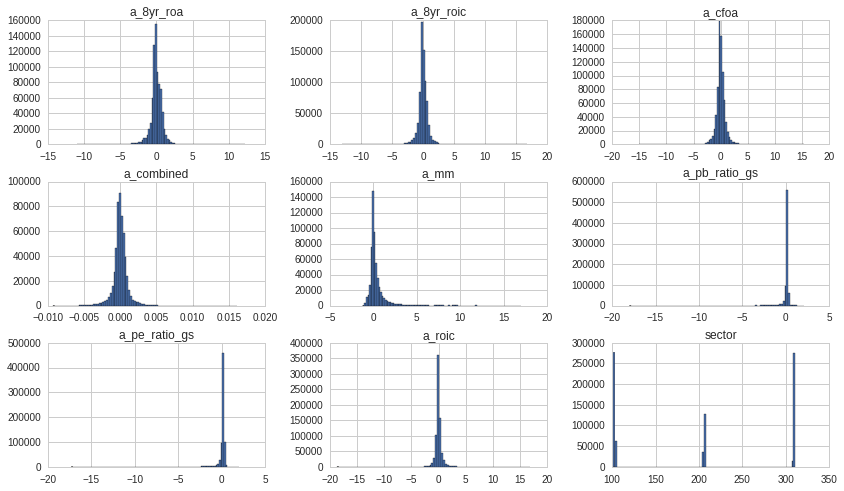

In [11]:
mdf.hist(bins=100);

### 5.3. Correlation between factors

Correlation close to 1.0 (or -1.0) means the factor is probably not needed.

In [12]:
mdf.fillna(0).corr()  # Filling NaNs with 0 assumes empty values are the mean (z-score/rank of 0)
# mdf.corr()  # Drops NaNs; results are not much different

,a_8yr_roa,a_8yr_roic,a_cfoa,a_combined,a_mm,a_pb_ratio_gs,a_pe_ratio_gs,a_roic,sector
a_8yr_roa,1.000000e+00,7.101458e-01,3.944044e-01,0.526417,-0.002721,-3.432086e-02,6.764218e-02,4.026386e-01,-4.185753e-17
a_8yr_roic,7.101458e-01,1.000000e+00,3.515907e-01,0.490680,0.004421,-6.537076e-02,4.403748e-02,3.969741e-01,-1.806235e-17
a_cfoa,3.944044e-01,3.515907e-01,1.000000e+00,0.432184,0.000309,-9.359397e-03,1.765295e-02,2.131289e-01,1.109576e-17
a_combined,5.264166e-01,4.906804e-01,4.321837e-01,1.000000,0.305521,9.806020e-02,3.301963e-01,4.291206e-01,-2.106211e-03
a_mm,-2.721207e-03,4.420912e-03,3.087886e-04,0.305521,1.000000,-3.591784e-02,-1.165537e-02,3.209978e-02,3.176763e-02
a_pb_ratio_gs,-3.432086e-02,-6.537076e-02,-9.359397e-03,0.098060,-0.035918,1.000000e+00,1.274465e-02,-7.047861e-03,7.199102e-18
a_pe_ratio_gs,6.764218e-02,4.403748e-02,1.765295e-02,0.330196,-0.011655,1.274465e-02,1.000000e+00,5.781497e-02,-9.639519e-18
a_roic,4.026386e-01,3.969741e-01,2.131289e-01,0.429121,0.032100,-7.047861e-03,5.781497e-02,1.000000e+00,9.056913e-17
sector,-4.185753e-17,-1.806235e-17,1.109576e-17,-0.002106,0.031768,7.199102e-18,-9.639519e-18,9.056913e-17,1.000000e+00


### 5.4. Number of stocks to trade

1. Total number of stocks considered for trading throughout all dates:

In [13]:
mdf.index.get_level_values(1).unique().shape

(2570,)

2. How many stocks on average do we trade each day?

In [14]:
mdf.dropna().groupby(level=0).agg('count').mean()[0]

1515.5533707865168

## 6. Get Alpha Factors
 
We have a function below to extract alpha factors from the `factors` DataFrame we have created above. It does two things by default:

1. Replace `np.inf` and `np.nan` to 0, and
2. get the `factors['a_combined']` Series.

Although you may technically combine the alphas in this function, it is preferable to do the alpha combination step on the "Build Pipeline" step above. The reasoning:

The algorithm environment requires this function to accept a $1 \times s$ DataFrame where $s$ is the number of assets, while this research environment requires a $d \times s$ DataFrame where $d$ is the number of dates. Due to this, performing complex operations (such as getting only the extreme values of the combined alpha) may take a very long time on the Notebook environment.

In [15]:
# Note: Adjust as necessary. In here, columns that begins with 'a_' would be
#       considered alpha factors. The rest are for analysis purposes.

filter_col = [col for col in mdf if col.startswith('a_')]
alphas = mdf.loc[:, filter_col]

# Note: Copy to the algorithm

def get_alpha(factors):
    # Replace infs and NaNs
    factors[np.isinf(factors)] = np.nan
    factors.fillna(0, inplace=True)

    combined_alpha = factors['a_combined']
    return combined_alpha

The trading algorithm will use the `combined_alpha` DataFrame.

In [16]:
combined_alpha = get_alpha(alphas)

## 7. Analyze Alphas

### 7.1. Alphas' Statistics

Present some statistics of the alphas here.

In [17]:
alphas.describe()

,a_8yr_roa,a_8yr_roic,a_cfoa,a_combined,a_mm,a_pb_ratio_gs,a_pe_ratio_gs,a_roic
count,7.907010e+05,7.907010e+05,7.907010e+05,7.907010e+05,790701.000000,7.907010e+05,7.907010e+05,7.907010e+05
mean,-9.802775e-18,2.818697e-17,1.000994e-17,2.975725e-21,0.278287,-7.590563e-19,-6.922492e-18,-4.546118e-17
std,9.922458e-01,9.802127e-01,9.871605e-01,8.579337e-04,1.067652,9.952226e-01,9.698985e-01,9.904393e-01
min,-1.120643e+01,-1.329865e+01,-1.542651e+01,-9.314636e-03,-1.233756,-1.801808e+01,-1.731896e+01,-1.873607e+01
25%,-3.596369e-01,-3.059356e-01,-3.476123e-01,-2.112556e-04,-0.055168,7.154240e-02,7.888677e-02,-1.778646e-01
50%,-5.246159e-02,-2.271655e-02,-1.290450e-02,0.000000e+00,0.000000,1.413623e-01,1.843415e-01,1.085545e-02
75%,4.316633e-01,3.369802e-01,3.826547e-01,2.075709e-04,0.258003,1.897652e-01,2.514143e-01,1.867317e-01
max,1.224012e+01,1.678141e+01,1.529623e+01,1.607293e-02,17.045660,2.069429e+00,2.034580e+00,1.684404e+01


How many % of our signals are shorts?

In [18]:
median_daily_signals = alphas.groupby(level=0).count().median()
percent_short = float(combined_alpha[combined_alpha < 0.0].count()) \
                / float(combined_alpha.count())*100

print("Median number of daily signals: {}".format(median_daily_signals))
print("% of short signals: {}%".format(percent_short))

Median number of daily signals: a_8yr_roa        2214.0
a_8yr_roic       2214.0
a_cfoa           2214.0
a_combined       2214.0
a_mm             2214.0
a_pb_ratio_gs    2214.0
a_pe_ratio_gs    2214.0
a_roic           2214.0
dtype: float64
% of short signals: 34.917117848592575%


### 7.2. Alphalens Analysis

`ANALYZE_ALL` settings:

1. `True`: Analyze all alpha factors in variable `alphas` and the final `combined_alpha` variable.
2. `False`: Analyze only the final factor i.e. the `combined_alpha` variable.

In [19]:
ANALYZE_ALL = False

if ANALYZE_ALL:
    alphas_view = alphas.copy()
else:
    alphas_view = pd.DataFrame({'aa_combined': combined_alpha})
alphas_view.head(5)

aa_combined
2018-01-02 00:00:00+00:00 Equity(2 [HWM])      -0.000547
                          Equity(24 [AAPL])     0.000699
                          Equity(31 [ABAX])     0.000592
                          Equity(41 [ARCB])    -0.000306
                          Equity(52 [ABM])     -0.000092

In [20]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 1 day, 1 week, 1 month, 1 quarter
periods = [1, 5, 22, 64]

# Get pricing data (extends 6 months to minimize dropping in Alphalens)
new_start_date = start_date - relativedelta(months=6)
new_end_date = end_date + relativedelta(months=6)
assets = alphas_view.reset_index()['level_1'].unique()
dates = alphas_view.reset_index()['level_0'].unique()
prices = get_pricing(assets, start_date=new_start_date, end_date=new_end_date, fields='close_price')
prices.head(5)

,Equity(2 [HWM]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [GOLD]),Equity(67 [ADSK]),Equity(76 [TAP]),...,Equity(40848 [FLDM]),Equity(7259 [SXI]),Equity(16743 [DX]),Equity(51995 [TALO]),Equity(50695 [PSDO]),Equity(52361 [BPYU]),Equity(52362 [KLXE]),Equity(4886 [MITK]),Equity(49607 [AXSM]),Equity(38296 [RST])
2017-07-03 00:00:00+00:00,22.350,138.253,52.992,20.851,39.769,142.38,46.557,15.191,99.340,80.451,...,4.115,89.422,15.930,NaN,14.141,NaN,NaN,8.25,5.30,10.69
2017-07-05 00:00:00+00:00,22.506,138.812,52.754,20.509,39.358,142.31,46.834,15.522,102.610,80.572,...,3.770,88.396,15.976,NaN,14.496,NaN,NaN,8.20,5.15,10.49
2017-07-06 00:00:00+00:00,22.438,137.492,51.755,20.314,38.785,140.02,45.849,15.240,102.060,80.292,...,3.800,88.836,15.771,NaN,13.983,NaN,NaN,8.25,5.30,10.39
2017-07-07 00:00:00+00:00,22.624,138.889,52.052,21.046,39.320,142.12,46.299,14.963,103.320,80.237,...,3.900,89.960,15.680,NaN,14.447,NaN,NaN,8.50,5.50,10.72
2017-07-10 00:00:00+00:00,23.318,139.775,51.641,21.388,38.900,141.21,46.117,15.376,103.745,79.761,...,3.960,89.471,15.520,NaN,14.289,NaN,NaN,9.45,5.45,10.48


In [21]:
import alphalens as al
from scipy import stats

def get_table(ic_data, ab_data):
    summary_table = pd.DataFrame()
    summary_table["Ann. Alpha"] = ab_data.loc['Ann. alpha']
    summary_table["beta"] = ab_data.loc['beta']
    summary_table["IC Mean"] = ic_data.mean()
    summary_table["IC Std."] = ic_data.std()
    summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    summary_table["p-value(IC)"] = p_value

    return summary_table.apply(lambda x: x.round(3)).T


results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    data = alphas_view[col]
    data = data[data != 0].dropna()
#     try:
    factor_data = al.utils.get_clean_factor_and_forward_returns(data,
                                                                prices,
                                                                quantiles=5,
                                                                periods=periods,
                                                                max_loss=1.
                                                               )

    # Output the results
    ic = al.performance.factor_information_coefficient(factor_data)
    ic.columns = pd.MultiIndex.from_product([[col], ic.columns])

    returns = al.performance.factor_returns(factor_data)
    ab = al.performance.factor_alpha_beta(factor_data, returns=returns)
    ab.columns = pd.MultiIndex.from_product([[col], ab.columns])

    table = get_table(ic, ab)

    if results is None:
        results = table
    else:
        results = pd.concat([results, table], axis=1)
            
#     except Exception as e:
#         print('Error: {}'.format(e))
#         continue
        
temp = None
i = 0
unique_vals = results.columns.get_level_values(0).unique()
for j, factor in enumerate(sorted(unique_vals)):
    i += 1
    res = results.xs(factor, axis=1, level=0, drop_level=False)
    
    if temp is None:
        temp = res
    else:
        temp = pd.concat([temp, res], axis=1)
        
    if i > 4 or j == len(unique_vals) - 1:
        display(temp)
        temp = None
        i = 0

aa_combined
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


aa_combined                     
                          1D     5D    22D    64D
Ann. Alpha             0.033  0.034  0.028  0.027
beta                  -0.045 -0.057 -0.024 -0.010
IC Mean                0.007  0.015  0.024  0.038
IC Std.                0.059  0.063  0.057  0.042
Risk-Adjusted IC       0.123  0.237  0.430  0.911
p-value(IC)            0.021  0.000  0.000  0.000

## 8. Tear Sheet Analysis

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import empyrical as ep
import alphalens as al
import pyfolio as pf

from quantopian.research.experimental import get_factor_returns, get_factor_loadings

MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start_date, new_end_date)
factor_returns = get_factor_returns(start_date, new_end_date)

# Fix a bug in the risk returns
factor_returns.loc[factor_returns.value.idxmax(), 'value'] = 0

def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def compute_turnover(df):
    return df.dropna().unstack().dropna(how='all').fillna(0).diff().abs().sum(1)

def get_max_median_position_concentration(expos):
    longs = expos.loc[expos > 0]
    shorts = expos.loc[expos < 0]

    return expos.groupby(level=0).quantile([.05, .25, .5, .75, .95]).unstack()

def compute_factor_stats(factor, pricing, factor_returns,
                         factor_loadings, periods=range(1, 15),
                         view=None):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    # closure
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                                factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                                factor_returns, factor_loadings)
    
    if view is None:
        perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
    else:
        perf_attrib = view.map_sync(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    turnover = compute_turnover(factor)
    n_holdings = factor.groupby(level=0).count()
    perc_holdings = get_max_median_position_concentration(factor)
    
    return {'factor_data_total': factor_data_total, 
            'portfolio_returns_total': portfolio_returns_total,
            'portfolio_returns_specific': portfolio_returns_specific,
            'risk_exposures_portfolio': risk_exposures_portfolio,
            'perf_attribution': perf_attribution,
            'delay_sharpes_total': delay_sharpes_total,
            'delay_sharpes_specific': delay_sharpes_specific,
            'turnover': turnover,
            'n_holdings': n_holdings,
            'perc_holdings': perc_holdings,
    }

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings,
                             periods=range(1, 15), view=None):
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(5, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])
    
    factor_stats = compute_factor_stats(factor, pricing, factor_returns, factor_loadings,
                                        periods=periods, view=view)
                         
    sharpes = pd.DataFrame({'specific': factor_stats['delay_sharpes_specific'], 
                  'total': factor_stats['delay_sharpes_total']})
#     display(sharpes)
    sharpes.plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = factor_stats['portfolio_returns_total'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = factor_stats['portfolio_returns_specific'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(factor_stats['risk_exposures_portfolio'].reindex(columns=factor_stats['perf_attribution'].columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(factor_stats['perf_attribution']).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    factor_stats['perf_attribution'].apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    ax6 = plt.subplot(gs[-1, 0:2])
    factor_stats['n_holdings'].plot(color='b', ax=ax6)
    ax6.set_ylabel('# holdings', color='b')
    ax6.tick_params(axis='y', labelcolor='b')
    
    ax62 = ax6.twinx()
    factor_stats['turnover'].plot(color='r', ax=ax62)
    ax62.set_ylabel('turnover', color='r')
    ax62.tick_params(axis='y', labelcolor='r')
    
    ax7 = plt.subplot(gs[-1, 2:4])
    factor_stats['perc_holdings'].plot(ax=ax7)
    ax7.set_ylabel('Holdings Ratio')
    
    gs.tight_layout(fig)
    
    return fig, factor_stats, sharpes

/venvs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


aa_combined
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


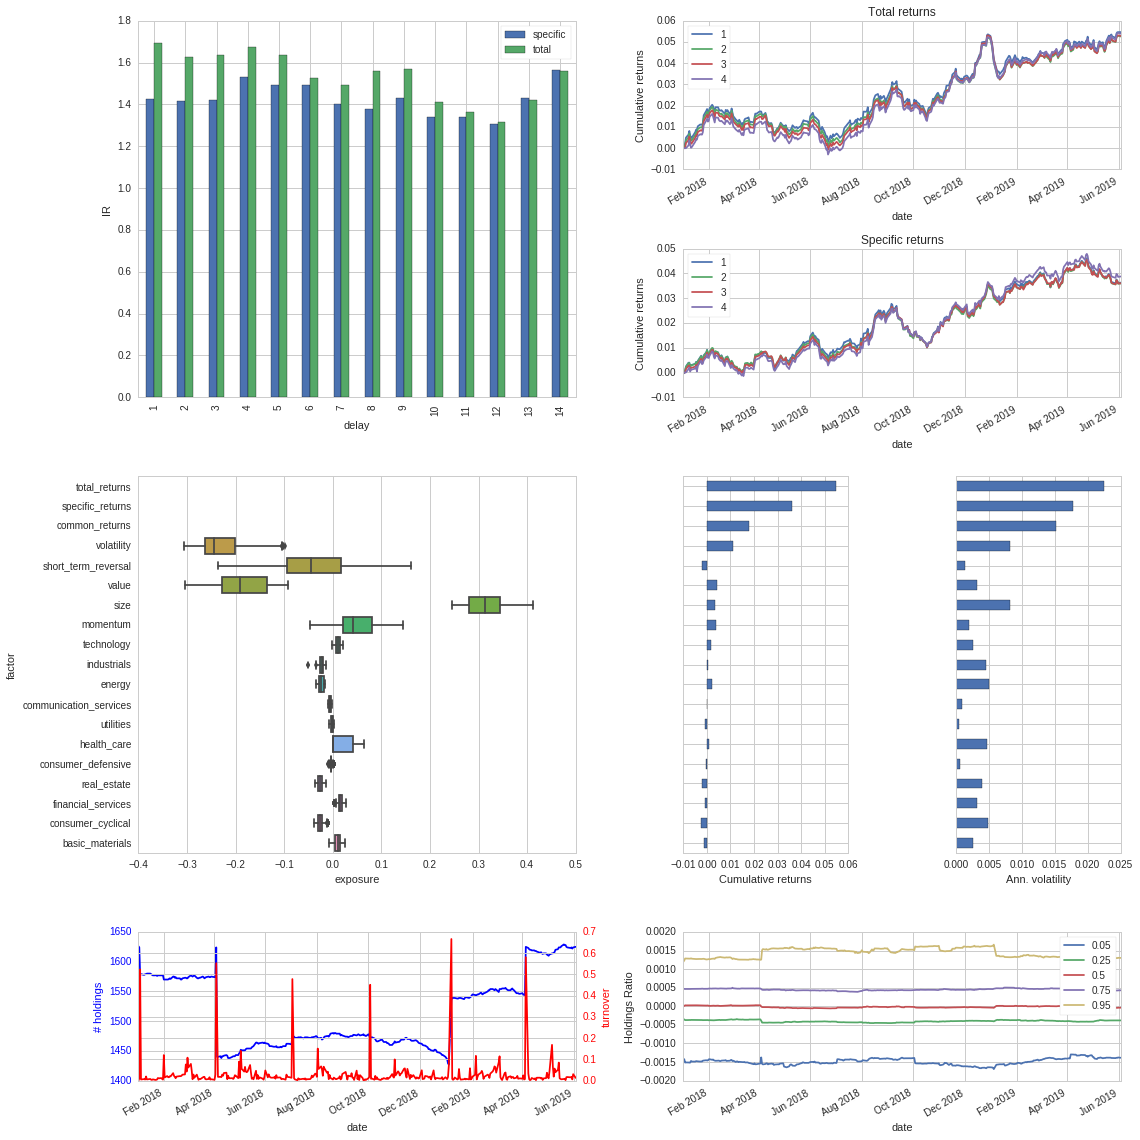

In [23]:
# Loop through all columns
results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    try:
        data = alphas_view[col]
        data = data[data != 0].dropna()
        fig, factor_stats, sharpes = plot_overview_tear_sheet(data,
                                                     prices,
                                                     factor_returns,
                                                     factor_loadings);
        plt.show()
        
        sharpes.columns = pd.MultiIndex.from_product([[col], sharpes.columns])
        if results is None:
            results = sharpes
        else:
            results = pd.concat([results, sharpes], axis=1)
        
    except Exception as e:
        print('Error: {}'.format(e))
        continue
        
# results

In [24]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

sectors = mdf['sector']

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=alphas['a_roic'],
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods, max_loss=1000)

Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100000.0%, not exceeded: OK!


In [25]:
combined_alpha.describe()

count    7.907010e+05
mean     2.975725e-21
std      8.579337e-04
min     -9.314636e-03
25%     -2.112556e-04
50%      0.000000e+00
75%      2.075709e-04
max      1.607293e-02
Name: a_combined, dtype: float64

In [26]:
factor_data.head()

1D        5D       22D  \
date                      asset                                             
2018-01-02 00:00:00+00:00 Equity(2 [HWM])    0.007584  0.074229  0.050744   
                          Equity(24 [AAPL]) -0.000407  0.012070 -0.068742   
                          Equity(31 [ABAX]) -0.009583  0.230799  0.412014   
                          Equity(41 [ARCB]) -0.018931 -0.020280 -0.014859   
                          Equity(52 [ABM])   0.003866  0.051527 -0.012371   

                                                  64D    factor        group  \
date                      asset                                                
2018-01-02 00:00:00+00:00 Equity(2 [HWM])   -0.166557 -0.325082  Industrials   
                          Equity(24 [AAPL])  0.007219  0.101807   Technology   
                          Equity(31 [ABAX])  0.421336  0.173764   Healthcare   
                          Equity(41 [ARCB]) -0.084420 -0.183902  Industrials   
                          Equity(52 [ABM])  -0.102447  0.107794  Industrials   

                                             factor_quantile  
date                      asset                               
2018-01-02 00:00:00+00:00 Equity(2 [HWM])                  1  
                          Equity(24 [AAPL])                4  
                          Equity(31 [ABAX])                4  
                          Equity(41 [ARCB])                2  
                          Equity(52 [ABM])                 4

In [ ]:
al.tears.create_returns_tear_sheet(factor_data, by_group=True)

Returns Analysis


,1D,5D,22D,64D
Ann. alpha,0.050,0.045,0.030,0.025
beta,-0.078,-0.102,-0.098,-0.073
Mean Period Wise Return Top Quantile (bps),1.157,1.424,1.282,1.126
Mean Period Wise Return Bottom Quantile (bps),-1.163,-1.156,-0.414,-0.280
Mean Period Wise Spread (bps),2.320,2.567,1.679,1.389
